# <p style="background-color:#DAF022;font-family:newtimeroman;color:#1C1C1A;font-size:100%;text-align:center;border-radius:40px 40px;"><b>Identifying Entities in Healthcare Data</b></p>

## Workspace set up: Import and Install useful packages.

In [26]:
!pip install pycrf
!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

  Preparing metadata (setup.py) ... done
  Created wheel for pycrf: filename=pycrf-0.0.1-py3-none-any.whl size=1896 sha256=48835d0fd546019304a734644fdadb373e6c938b238b782b76f2842d6451d292
  Stored in directory: /root/.cache/pip/wheels/fd/3a/fb/e4d15c9c2b169f43811b23a863ee9717ff3eda5d2301789043
Successfully built pycrf


## Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

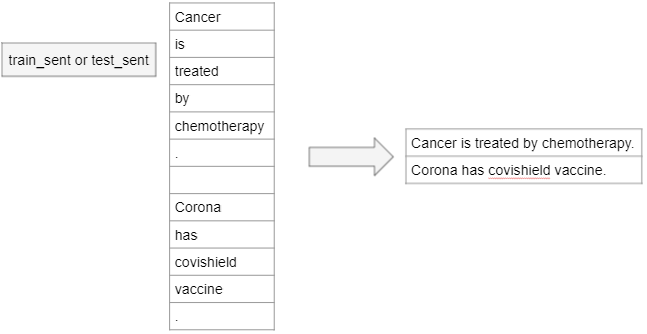

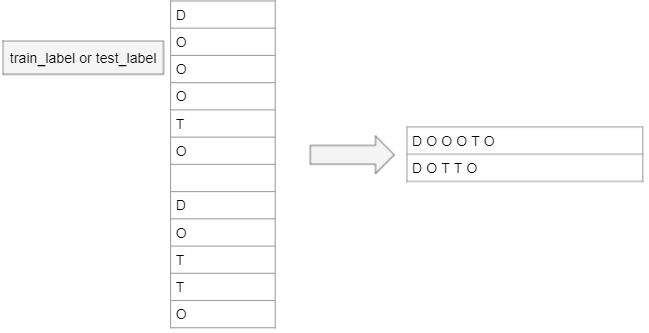

In [27]:
def process_file(filename):
    input_file = open(filename, 'r')
    file_content = input_file.readlines()
    input_file.close()
    
    out_lines = []
    
    line_content = ''
    
    for word in file_content:
        word = word.strip()
        if word == "":
            out_lines.append(line_content)
            line_content = ""
        else:
            if line_content:
                line_content += " "+word
            else:
                line_content = word
    return out_lines

In [28]:
train_sent = process_file('/kaggle/input/documents/train_sent')
test_sent = process_file('/kaggle/input/documents/test_sent')

train_label = process_file('/kaggle/input/documents/train_label')
test_label = process_file('/kaggle/input/documents/test_label')

In [29]:
print(train_sent[0:2])

['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )', 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )']


In [30]:
print(test_sent[0])

Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )


In [31]:
print(train_label[0:2])

['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O']


In [32]:
print(test_label[0:2])

['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O']


**Assign variable train_sent, test_sent, train_label, test_label to their respective files.**

### Count the number of sentences in the processed train and test dataset 

In [33]:
print(len(train_sent),'\n')
print(len(test_sent),'\n')

2599 

1056 



### Count the number of lines of labels in the processed train and test dataset.

In [34]:
print(len(test_label),'\n')

print(len(test_label),'\n')

1056 

1056 



In [40]:
for i in range(0,5):
    print('#####################')
    print("Sentence number %d" %i)
    print(train_sent[i])
    print("Label number %d" %i)
    print(train_label[i])

#####################
Sentence number 0
All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
Label number 0
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
#####################
Sentence number 1
The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Label number 1
O O O O O O O O O O O O O O O O O O O O O O O O O
#####################
Sentence number 2
Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
Label number 2
O O O O O O O O O O O O O O O
#####################
Sentence number 3
The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )
Label number 3
O O O O O O O

In [41]:
for i in range(0,5):
    print('#####################')
    print("Sentence number %d" %i)
    print(test_sent[i])
    print("Label number %d" %i)
    print(test_label[i])

#####################
Sentence number 0
Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )
Label number 0
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
#####################
Sentence number 1
As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration
Label number 1
O O O O O O O O O O O O O O O O O O O
#####################
Sentence number 2
The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period
Label number 2
O O O O O O O O O O O O O O O O O O O O O O O O
#####################
Sentence number 3
There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 

## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [44]:
count = 0

for i in range(0,len(train_sent)):
    sent = model(train_sent[i])

    for token in sent:
        if(token.pos_ in ["NOUN","PROPN"]):
            count += 1

print("TRAIN SET Containing: Total no of words which are NOUN or PROPN = ", count)

TRAIN SET Containing: Total no of words which are NOUN or PROPN =  17439


In [46]:
count = 0

for i in range(0,len(test_sent)):
    sent = model(test_sent[i])

    for token in sent:
        if(token.pos_ in ["NOUN","PROPN"]):
            count += 1

print("TEST SET Containing: Total no of words which are NOUN or PROPN = ", count)

TEST SET Containing: Total no of words which are NOUN or PROPN =  6934


I am processing through each sentences in both `train` & `test data` and seeing if the word is having a PoS tag named as **'NOUN' or 'PROPN'**. If yes, then increasing the no of count else pass.

**Let's Find the Frequency Now**

In [48]:
frequency = {}

for i in (train_sent, test_sent):
    for j in i:
        processed_sentence = model(j)
        
        for token in processed_sentence:
            if(token.pos_ == 'NOUN' or token.pos_ == 'PROPN'):
                frequency[token.text] = frequency.get(token.text, 0) + 1

In [49]:
print('##################')
frequency

##################


{'births': 2,
 'weeks': 37,
 'University': 6,
 'Vermont': 1,
 'delivery': 20,
 'route': 2,
 'indication': 5,
 'age': 56,
 'parity': 4,
 'practice': 31,
 'group': 94,
 'risk': 71,
 'status': 17,
 'rate': 67,
 '%': 247,
 'presentation': 7,
 'medicine': 36,
 'patients': 492,
 'Arrest': 1,
 'dilation': 4,
 'subgroups': 4,
 'rates': 34,
 'care': 56,
 'hospitals': 10,
 'community': 15,
 'groups': 34,
 'trimester': 4,
 'fluid': 8,
 'index': 13,
 'AFI': 8,
 'temperature': 10,
 'increases': 8,
 'decrease': 5,
 'June': 2,
 'August': 6,
 'period': 28,
 'heat': 5,
 'women': 77,
 'singleton': 1,
 'pregnancies': 7,
 'gestation': 4,
 'testing': 25,
 'determinations': 2,
 'ambient': 1,
 'area': 11,
 'day': 36,
 'mean': 3,
 'test': 20,
 'date': 3,
 'Spearman': 1,
 'rank': 2,
 'Correlation': 3,
 'relationship': 12,
 'account': 4,
 'measure': 4,
 'well': 2,
 'being': 2,
 'study': 154,
 'population': 31,
 'diabetes': 31,
 'screening': 12,
 'clinic': 5,
 'Hadassah': 1,
 'Medical': 6,
 'Center': 3,
 'year':

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [56]:
#Let's sort the frequency dictionary values

sorted_frequency = list(sorted(frequency.items(), key = lambda item:item[1], reverse = True)[:25])
print(sorted_frequency)

[('patients', 492), ('treatment', 281), ('%', 247), ('cancer', 200), ('therapy', 175), ('study', 154), ('disease', 142), ('cell', 140), ('lung', 116), ('group', 94), ('chemotherapy', 88), ('gene', 87), ('effects', 85), ('results', 79), ('women', 77), ('use', 74), ('TO_SEE', 74), ('risk', 71), ('cases', 71), ('surgery', 71), ('analysis', 70), ('rate', 67), ('response', 66), ('survival', 65), ('children', 64)]


**As i have already converted the NOUN and PROPN to a dictionary. I am just sorting here the values one using lambda function. and showing the top 25 mostly used token of NOUN and PROPN.**

## Defining features for CRF





We will proceed with training a custom Conditional Random Field (CRF) model to identify diseases (D) and treatments (T) from the given data. To ensure accurate feature representation, we need to define all the features correctly. In this case, we will only consider the previous word along with the current word to evaluate additional features.

Furthermore, it is important to properly mark the beginning (BEG) and end (END) words in the dataset. Additionally, we need to ensure that the Part-of-Speech (POS) tags (pos_tags) have been correctly provided and utilized in the method.

Throughout the training process, we will make use of the features we have previously studied and implemented. By adhering to these guidelines, we can effectively train and evaluate the CRF model on the provided training and test datasets.

Below are some examples :

* Treatment words ending with 'tion' = radiation, implantation, anticogulation

* Treatment words ending with 'tic' = antipileptic, anitbiotic

* Treatment words ending with 'omy' = vitrecomy, prostatectomy

* Treatment words ending with 'ery' = surgery, artery

* Treatment words ending with 'apy' = monotherapy, therapy

In [57]:
# Let's define the features to get the feature value for one word.
def getPOStag(word):
    for a in word:
        return(a.pos_)
    
def getLast3chars(word):
    if word[-3:] in ["mic","ery","ear","tic","apy","tic","omy","ese","tes","ome","ial","oma","sis","ary","hea","gus"]:
        return "1"
    else:
        return "0"
    
def getLast4chars(word):
    if word[-4:] in ["gery","tion","ment","lear","date","ptic","elet","sive","sion","mine","esis","rgic","tomy","nary","rugs","llin","ides","mide","bial","tery","ytic","onal","rial","ease","thma","enza"]:
        return "1"
    else:
        return "0"
    
def getFirst4chars(word):
    if word[0:4] in ["anti","cycl","impl","mono","gest","diab","mito","mela","meta"]:
        return "1"
    else:
        return "0"

* This code defines four functions: **getPOStag, getLast3chars, getLast4chars, and getFirst4chars.**
* The `getPOStag` function takes a word as input and returns the part-of-speech tag of the first character in the word.
* The `getLast3chars` function checks if the last three characters of a word match any of the given strings and returns "1" if there is a match, otherwise "0".
* The `getLast4chars` function checks if the last four characters of a word match any of the given strings and returns "1" if there is a match, otherwise "0".
* The `getFirst4chars` function checks if the first four characters of a word match any of the given strings and returns "1" if there is a match, otherwise "0".

In [58]:
# Let's define the features to get the feature value for one word.
def getFeaturesForOneWord(sentence, pos):
  word = sentence[pos]
  doc1=model(word)

  features = [
    'word.lower=' + word.lower(), 
    'word.isupper=%s' % word.isupper(), 
    'word.isdigit=%s' % word.isdigit(),  
    'word.startsWithCapital=%s' % word[0].isupper(),  
    'word[-3:]=' + word[-3:],
    'word[-4:]=' + word[-4:], 
    'word[0:4]=' + word[0:4], 
    'last3=%s' % getLast3chars(word),
    'last4=%s' % getLast4chars(word),
    'first4=%s' % getFirst4chars(word),
    'word.POStag=%s' % getPOStag(doc1)
  ]

  if(pos > 0):
    prev_word = sentence[pos-1]
    doc2=model(prev_word)
    features.extend([
    'prev_word.lower=' + prev_word.lower(), 
    'prev_word.isupper=%s' % prev_word.isupper(),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
    'prev_word[-3:]=' + prev_word[-3:],
    'prev_word.POStag=%s' % getPOStag(doc2)
  ])
  else:
    features.append('BEG') 

  if(pos == len(sentence)-1):
    features.append('END') 

  return features

* This code defines a function named `getFeaturesForOneWord` that takes a sentence and a position as input.
* The function extracts various features for a given word in the sentence, such as lowercase form, uppercase form, digit presence, capitalization of the first letter, last three characters, last four characters, first four characters, and part-of-speech tag.
* It calls the `getLast3chars`, `getLast4chars`, and `getFirst4chars` functions to determine additional features based on the word's character patterns.
* If the word is not the first word in the sentence, it also extracts features from the previous word, such as lowercase form, uppercase form, digit presence, capitalization of the first letter, last three characters, and part-of-speech tag.
* Special features **'BEG'** and **'END'** are added to indicate the beginning and end of the sentence, respectively. The function returns a list of extracted features.

## Getting the features

### Write a code/function to get the features for a sentence

In [59]:
# Write a code to get features for a sentence.
def getFeaturesForOneSentence(sentence):
  sentence_list = sentence.split()
  return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]

* This code defines a function named `getFeaturesForOneSentence` that takes a sentence as input.
* The function splits the sentence into individual words using the split() method, and then iterates over each word's position to extract features using the `getFeaturesForOneWord` function. It returns a list of features for each word in the sentence.

### Write a code/function to get the labels of a sentence

In [60]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
  return labels.split()

The code defines a function named `getLabelsInListForOneSentence` that takes a string of labels as input. It splits the labels into individual items using the split() method and returns them as a list.

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [62]:
from tqdm import tqdm
print("Generating features for Train sentences")
X_train = [getFeaturesForOneSentence(sentence) for sentence in tqdm(train_sent)]
print("Generating features for Test sentences")
X_test = [getFeaturesForOneSentence(sentence) for sentence in tqdm(test_sent)]

Generating features for Train sentences


100%|██████████| 2599/2599 [06:05<00:00,  7.10it/s]


Generating features for Test sentences


100%|██████████| 1056/1056 [02:29<00:00,  7.08it/s]


* The code imports the `tqdm` module, which provides a progress bar for iterating over sequences. It then prints a message indicating that it is generating features for the train sentences.
* It uses a list comprehension with the `tqdm` function to iterate over the train_sent list and call the `getFeaturesForOneSentence` function for each sentence, generating features for the train data.

### Define the labels as the target variable for test and the train dataset

In [63]:
print("Generating features for Train labels")
Y_train = [getLabelsInListForOneSentence(labels) for labels in tqdm(train_label)]
print("Generating features for Test labels")
Y_test = [getLabelsInListForOneSentence(labels) for labels in tqdm(test_label)]

Generating features for Train labels


100%|██████████| 2599/2599 [00:00<00:00, 773998.59it/s]


Generating features for Test labels


100%|██████████| 1056/1056 [00:00<00:00, 677556.22it/s]


In [65]:
Y_train[2], Y_test[4]

(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])

In [67]:
#X_train
res = getFeaturesForOneSentence(test_sent[46])
res[-1]

['word.lower=radiotherapy',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word[-3:]=apy',
 'word[-4:]=rapy',
 'word[0:4]=radi',
 'last3=1',
 'last4=0',
 'first4=0',
 'word.POStag=NOUN',
 'prev_word.lower=by',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False',
 'prev_word[-3:]=by',
 'prev_word.POStag=ADP',
 'END']

## Build the CRF Model

In [68]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=250)
try:
    crf.fit(X_train, Y_train)
except AttributeError:
    pass

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

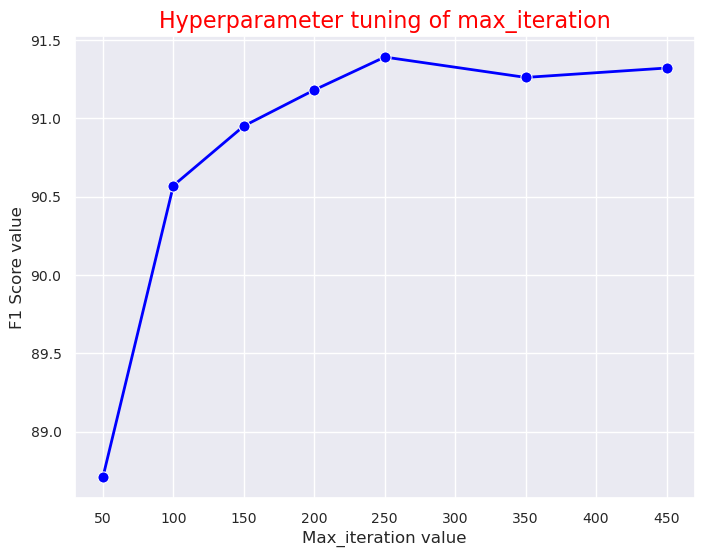

In [87]:
max_iter_list = [50, 100, 150, 200, 250, 350, 450]
f1_score = [88.71, 90.57, 90.95, 91.18, 91.39, 91.26, 91.32]

sns.set(style='darkgrid')
plt.figure(figsize=(8, 6))

sns.lineplot(x=max_iter_list, y=f1_score, color='blue', marker='o', markersize=8, linewidth=2)

plt.xlabel("Max_iteration value", fontsize=12)
plt.ylabel("F1 Score value", fontsize=12)
plt.title("Hyperparameter tuning of max_iteration", fontsize=16, color='red')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [73]:
Y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [74]:
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9192009774800166

## Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

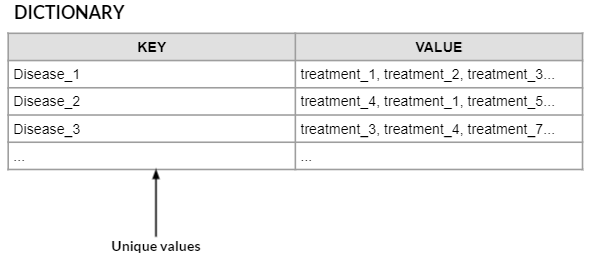

In [76]:
Mapping_dict=dict()

for lbl in range(0, len(Y_pred)):
  disease_sent=""
  treatment_sent=""
  label=Y_pred[lbl]
  for j in range(0, len(label)):
    if label[j]=='D':
      disease_sent=disease_sent+test_sent[lbl].split()[j]+" "
    if label[j]=='T':
      treatment_sent=treatment_sent+test_sent[lbl].split()[j]+" "
    
  disease_sent=disease_sent.lstrip().rstrip()
  treatment_sent=treatment_sent.lstrip().rstrip()
  
  
  if disease_sent!='' and treatment_sent!='':
    if disease_sent in Mapping_dict.keys():
      existing_disease_treatment=list(Mapping_dict[disease_sent]) 
      existing_disease_treatment.append(treatment_sent)
      Mapping_dict[disease_sent]=existing_disease_treatment
    else:
      Mapping_dict[disease_sent]=treatment_sent

* The code initializes an empty dictionary called `Mapping_dict` to store mappings between disease sentences and treatment sentences.

* It iterates over the predicted labels Y_pred and for each label, it constructs disease sentences and treatment sentences based on the corresponding positions in the `test_sent` sentences.

* It checks if both the disease sentence and treatment sentence are not empty. If they are not empty, it checks if the disease sentence already exists as a key in `Mapping_dict`. If it does, it retrieves the existing list of treatment sentences associated with that disease sentence, appends the new treatment sentence, and updates the dictionary. If the disease sentence is not already in Mapping_dict, it adds a new key-value pair where the disease sentence maps to the treatment sentence.

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [77]:
Mapping_dict['hereditary retinoblastoma']

'radiotherapy'

In [82]:
result = []
for i in range(0, len(test_sent)):
    if 'retinoblastoma' in test_sent[i]:
        print("This is sentence number ", i , "in test data.")
        print("\n####Sentence####")
        print(test_sent[i])
        print("\n####Test Label####")
        print(test_label[i]) 
        print("\n####Predicted Label####")
        print(" ".join(Y_pred[i]))

This is sentence number  46 in test data.

####Sentence####
< TO_SEE > CONTEXT : There is a substantial risk of a second cancer for persons with hereditary retinoblastoma , which is enhanced by radiotherapy

####Test Label####
O O O O O O O O O O O O O O O O O O O O O O O O O

####Predicted Label####
O O O O O O O O O O O O O O O O O D D O O O O O T


## **Resources:**

1. **Ramakrushna Mohapatra:** itsramakrushna@gmail.com
2. **Soundarya A:** soundaryaanjanayya@gmail.com
3. **Rohit Bharadwaj Kallakuri:**  krbharadwaj08@gmail.com